## Principal Component Analysis (PCA linear model) and Multidimensionality Scaling (MDS non linear model)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn.neighbors as nb
import sklearn.utils.graph as ug
from time import time
from numpy import *
from sklearn.datasets import load_iris
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.preprocessing import LabelEncoder

from sklearn import manifold, datasets
from sklearn.decomposition import PCA
from scipy.spatial import distance as spd


In [ ]:
from google.colab import drive #comment out this line if you are using Colab
drive.mount("/content/gdrive/") 

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# importing the csv into DataFrame using Pandas
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Intro to DS//Group_19_data_cleaned.csv",encoding= 'unicode_escape',parse_dates=[0])
df.head(2)

,Unnamed: 0,Date,Rented Bike Count,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(Â°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,1
1,1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,1


In [ ]:
df = df.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()

In [ ]:
df = df.drop("Unnamed: 0",axis=1)

In [ ]:
df.Date = pd.to_datetime(df.Date, format="%Y/%m/%d")

In [ ]:
df.insert(1,"Day", df.Date.dt.day)
df.insert(2, "Month", df.Date.dt.month)
df.insert(3, "Year", df.Date.dt.year)

In [ ]:
df.columns = [i.split("(")[0].strip().title().replace(" ","_") for i in [*df.columns]]

In [ ]:
df.insert(3, 'WeekDay',df["Date"].dt.day_name())

In [ ]:
df.Year = df.Year.map({2017:0, 2018:1})

In [ ]:
df.Seasons = df.Seasons.map({"Winter":1, 'Autumn':2, 'Spring':3, 'Summer':4})

In [ ]:
df.insert(2, 'label_day_night', df['Hour'].apply(lambda x : 0 if (x<7) else( 1)))

In [ ]:
df["Working_Day"] = 1
df.loc[(df.WeekDay=="Saturday")|(df.WeeakDay=="Sunday"), "Working_Day"] = 0

In [ ]:
df

,Date,Day,label_day_night,Month,WeekDay,Year,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point_Temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,Working_Day
0,2017-01-12,12,0,1,Thursday,0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1,0,1,1
1,2017-01-12,12,0,1,Thursday,0,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1,0,1,1
2,2017-01-12,12,0,1,Thursday,0,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1,0,1,1
3,2017-01-12,12,0,1,Thursday,0,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1,0,1,1
4,2017-01-12,12,0,1,Thursday,0,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,30,1,11,Friday,1,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,2,0,1,1
8756,2018-11-30,30,1,11,Friday,1,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,2,0,1,1
8757,2018-11-30,30,1,11,Friday,1,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,2,0,1,1
8758,2018-11-30,30,1,11,Friday,1,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,2,0,1,1


In [ ]:
df.Humidity[df.Humidity==0] = df.Humidity.mean()

<ipython-input-402-64e5ed02f960>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Humidity[df.Humidity==0] = df.Humidity.mean()


In [ ]:
categoryVariableList = ["WeekDay"]
for var in categoryVariableList:
    df[var] = df[var].astype("category")

In [ ]:
for col in categoryVariableList:
    df_dummies_col = pd.get_dummies(df[col])
    
    df = pd.concat([df, df_dummies_col],axis=1)
    
    df.drop(col, axis=1, inplace=True)

In [ ]:
df.columns

Index(['Date', 'Day', 'label_day_night', 'Month', 'Year', 'Rented_Bike_Count',
       'Hour', 'Temperature', 'Humidity', 'Wind_Speed', 'Visibility',
       'Dew_Point_Temperature', 'Solar_Radiation', 'Rainfall', 'Snowfall',
       'Seasons', 'Holiday', 'Functioning_Day', 'Working_Day', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [ ]:
columns = df.columns.tolist()
columns.append(columns.pop(5))
df = df[columns]

In [ ]:
df.drop("Date",axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
df.describe()

,Day,label_day_night,Month,Year,Hour,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point_Temperature,...,Functioning_Day,Working_Day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Rented_Bike_Count
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,15.720548,0.708333,6.526027,0.915068,11.500000,12.882922,58.339252,1.715000,1436.825799,4.073813,...,0.966324,0.709589,0.139726,0.136986,0.142466,0.147945,0.142466,0.145205,0.145205,698.378196
std,8.796749,0.454556,3.448048,0.278796,6.922582,11.944825,20.199877,1.001968,608.298712,13.060369,...,0.180404,0.453978,0.346722,0.343853,0.349547,0.355066,0.349547,0.352328,0.352328,625.814518
min,1.000000,0.000000,1.000000,0.000000,0.000000,-17.800000,10.000000,0.100000,27.000000,-30.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,4.000000,1.000000,5.750000,3.500000,43.000000,0.900000,940.000000,-4.700000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,191.000000
50%,16.000000,1.000000,7.000000,1.000000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,504.500000
75%,23.000000,1.000000,10.000000,1.000000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1065.250000
max,31.000000,1.000000,12.000000,1.000000,23.000000,39.400000,98.000000,4.300000,2000.000000,27.200000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2355.000000


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler=StandardScaler() #standardize the data set using “standard scaler” library

In [ ]:
scaler.fit(df)

StandardScaler()

In [ ]:
scaled_features= scaler.transform(df)  

In [ ]:
df.columns

Index(['Day', 'label_day_night', 'Month', 'Year', 'Hour', 'Temperature',
       'Humidity', 'Wind_Speed', 'Visibility', 'Dew_Point_Temperature',
       'Solar_Radiation', 'Rainfall', 'Snowfall', 'Seasons', 'Holiday',
       'Functioning_Day', 'Working_Day', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Rented_Bike_Count'],
      dtype='object')

The next step is to change the scaled features (standardized data)
from a numpy array to a data frame for ease of using in the PCA.

In [ ]:
scaled_features=pd.DataFrame(scaled_features, columns=df.columns)

In [ ]:
scaled_features.head()

,Day,label_day_night,Month,Year,Hour,Temperature,Humidity,Wind_Speed,Visibility,Dew_Point_Temperature,...,Functioning_Day,Working_Day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Rented_Bike_Count
0,-0.42297,-1.558387,-1.602745,-3.282407,-1.661325,-1.513957,-1.056465,0.484075,0.925871,-1.659605,...,0.18668,0.639739,-0.403014,-0.39841,-0.407596,-0.416693,2.453412,-0.412155,-0.412155,-0.710120
1,-0.42297,-1.558387,-1.602745,-3.282407,-1.516862,-1.539074,-1.006957,-0.913255,0.925871,-1.659605,...,0.18668,0.639739,-0.403014,-0.39841,-0.407596,-0.416693,2.453412,-0.412155,-0.412155,-0.790021
2,-0.42297,-1.558387,-1.602745,-3.282407,-1.372399,-1.580936,-0.957449,-0.713636,0.925871,-1.667262,...,0.18668,0.639739,-0.403014,-0.39841,-0.407596,-0.416693,2.453412,-0.412155,-0.412155,-0.839559
3,-0.42297,-1.558387,-1.602745,-3.282407,-1.227936,-1.597680,-0.907941,-0.813446,0.925871,-1.659605,...,0.18668,0.639739,-0.403014,-0.39841,-0.407596,-0.416693,2.453412,-0.412155,-0.412155,-0.945028
4,-0.42297,-1.558387,-1.602745,-3.282407,-1.083473,-1.580936,-1.105973,0.583884,0.925871,-1.736177,...,0.18668,0.639739,-0.403014,-0.39841,-0.407596,-0.416693,2.453412,-0.412155,-0.412155,-0.991370


In [ ]:
from sklearn.decomposition import PCA #let’s import PCA from “sklearn.decomposition” 

In [ ]:
#data : the data matrix
#k the number of component to return
#return the new data and the variance that was maintained 
def pca1(data,k):
	# compute the mean

    m = np.mean(data,0)
	# subtract the mean (along columns)
    C = data-m
	# compute covariance matrix
    cov_mat = np.dot(transpose(C),C)
	# compute eigenvalues and eigenvectors of covariance matrix
    eigval,eigvect = linalg.eig(cov_mat)
	# Sort eigenvalues (their indexes)
    idx = eigval.argsort()[::-1]
    eigval[idx]
	# Sort eigenvectors according to eigenvalues
    vect = eigvect[:,idx]
    eigk = vect[:,0:k]
	# Project the data to the new space (k-D) and measure how much variance we kept
    data2 = np.dot(C,eigk)
    perc = sum(eigval[0:k])/sum(eigval)
    return  (data2, perc)#put here a tuple to return both

In [ ]:
#D :distance matrix
#k: number of vectors to use
def mds(D,k):
    nelem = D.shape[0]
    J = eye(nelem) - (1.0/nelem) * ones(nelem)
    # Compute matrix B
    B = -(1.0/2) * dot(J,dot(pow(D,2),J))
    # SVD decomposition of B  
    U,L,V = linalg.svd(B)
    return dot(U[:,:k],sqrt(diag(L)[:k,:k]))

PCA: 0.044 sec
MDS: 2.9e+02 sec


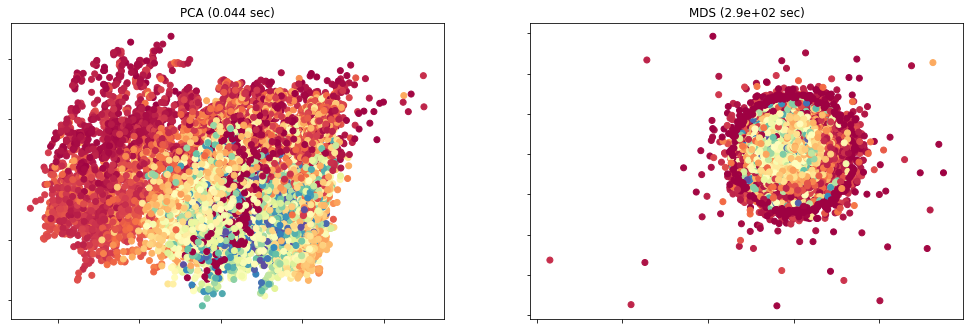

In [ ]:

X = scaled_features.iloc[:,:-1]
Y_iris = scaled_features['Rented_Bike_Count']
color = LabelEncoder().fit_transform(Y_iris)


n_components=2
n_neighbors=5

fig = plt.figure(figsize=(45, 12))
# #----PCA---------- sklearn implementation 

t0 = time()
pca = PCA(n_components=n_components)
Y_pca = pca.fit_transform(X)
t1 = time()
print("PCA: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("PCA (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
# #--------------------
# #----MDS---------- sklearn implementation (Stress minimization-majorization algorithm SMACOF)
t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y_mds = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y_mds[:, 0], Y_mds[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
# #---------------




plt.show()

In [ ]:
color.size

8760